#Importing Libraries and Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from scipy.special import inv_boxcox
import seaborn as sns

import pickle
import json

import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [2]:
# Import the library to mount Google Drive
from google.colab import drive

# Mount the Google Drive at /content/drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
exercises_df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Final Projects/Calories Burnt Prediction/Datasets/exercise.csv")
exercises_df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


In [4]:
calories_df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Final Projects/Calories Burnt Prediction/Datasets/calories.csv")
calories_df.head()

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


In [5]:
#Merging the Datasets
df = pd.merge(exercises_df, calories_df, on="User_ID", how='inner')
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [6]:
df.shape

(15000, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [8]:
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [9]:
calories_avg = int(df.describe()['Calories']['mean'])
print(f"Average calories burnt is {calories_avg}")

Average calories burnt is 89


#Exploratory Data Analysis

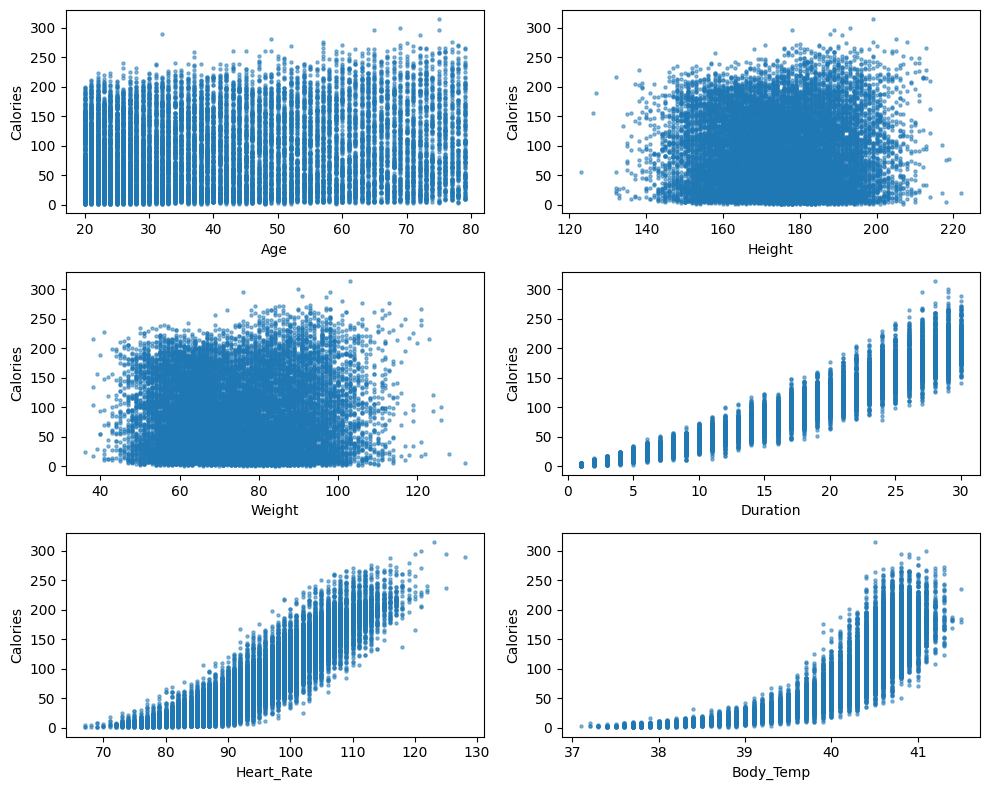

In [10]:
columns = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp", "Calories"]

# Plotting features against calories
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Flatteen the axes into 1D array
axes = axes.flatten()

for i, feature in enumerate(columns[:-1]):
    axes[i].scatter(df[feature], df["Calories"], alpha=0.5, s=5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Calories")

plt.tight_layout()
plt.show()

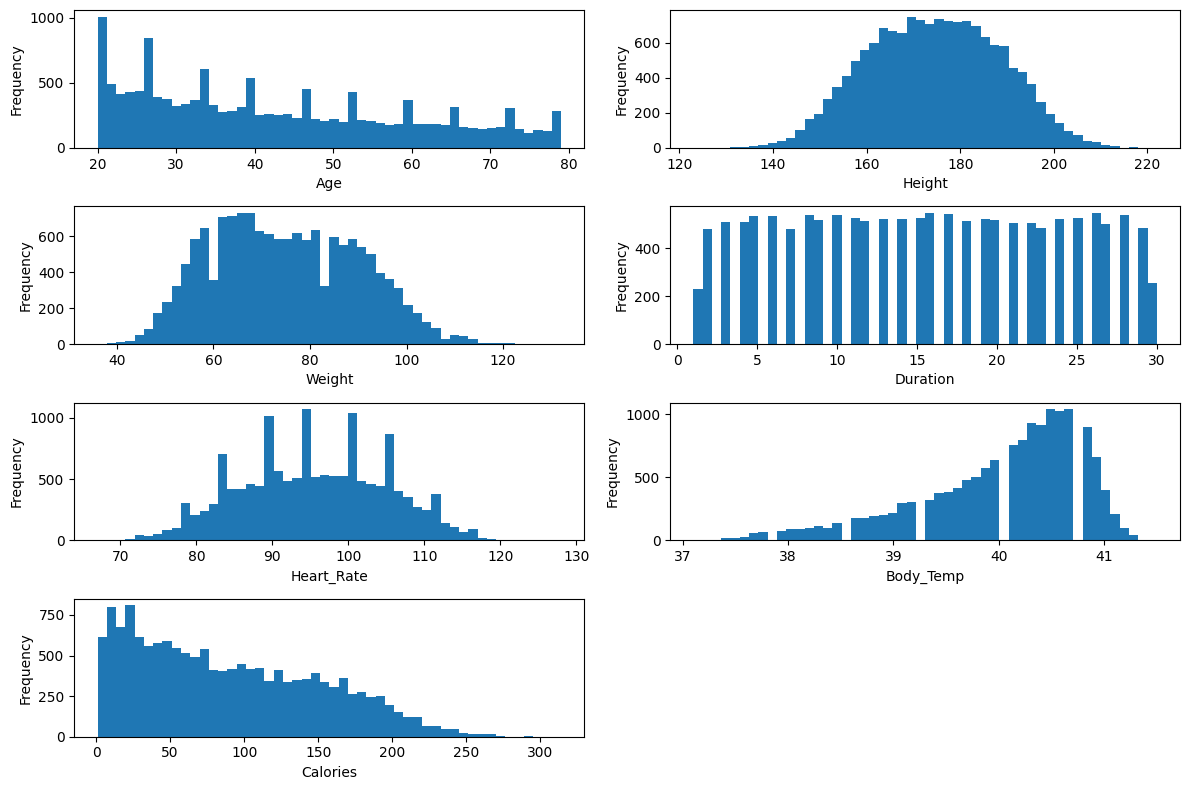

In [11]:
# Plotting the distributions of the features
fig, axes = plt.subplots(4, 2, figsize=(12, 8))

# Flatten the axes array into 1d array
axes = axes.flatten()
for i, feature in enumerate(columns):
    axes[i].hist(df[feature], bins=50)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")

axes[7].set_visible(False)
plt.tight_layout()
plt.show()

##Transforming data to be normally distributed

In [12]:
def transform_skewed(data):
    """Transforms skewed data to be more normally distributed."""

    return scipy.stats.boxcox(data + 1)

In [13]:
skewed_cols = ["Body_Temp", "Calories"]
boxcox_lambda = {}

# transform skewed features
for col in skewed_cols:
    trans_col_name = f"{col}_Trans"
    df[trans_col_name], boxcox_lambda[col] = transform_skewed(df[col])

    # Dropping the skewed columns
    df.drop(col, axis=1, inplace=True)


In [14]:
# save lambdas as a JSON file
path = "/content/drive/MyDrive/Machine Learning/Final Projects/Calories Burnt Prediction/lambda.json"

with open(path, "w") as f:
    json.dump(boxcox_lambda, f, indent=4)

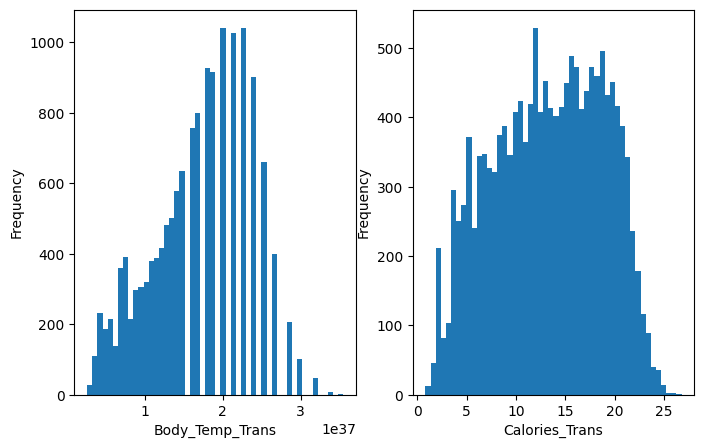

In [15]:
# Plotting the distribution of transformed columns
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

axes = axes.flatten()
for i in range(2):
    trans_col_name = f"{skewed_cols[i]}_Trans"
    axes[i].hist(df[trans_col_name], bins=50)
    axes[i].set_xlabel(trans_col_name)
    axes[i].set_ylabel("Frequency")
plt.show()

##Checking for outliers

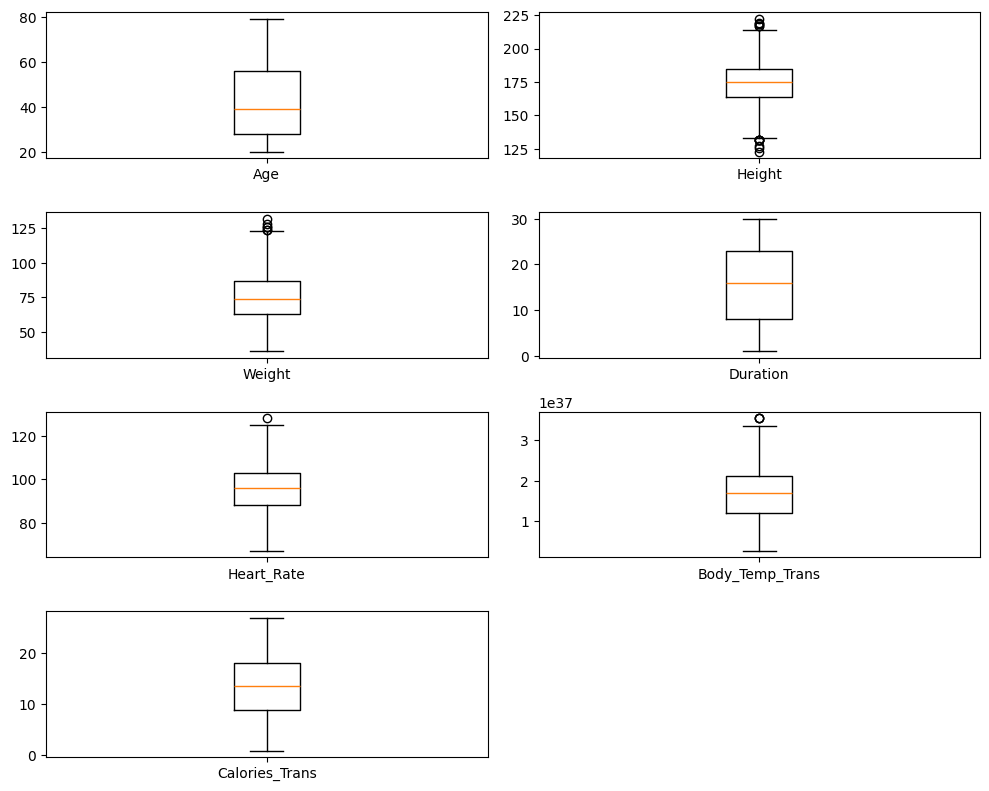

In [16]:
columns = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp_Trans", "Calories_Trans"]

def plot_boxplot(df, columns, title=None):
    """

    Plotting the boxplot for each Feature

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list of str): The list of column names for which boxplots will be generated.

    Returns:
    None: Displays the boxplots but does not return any value.
    """
    #creating a figure for plotting the boxplot of features
    fig, axes = plt.subplots(4, 2, figsize=(10, 8))

    #Flatten the axes list to iterate through it easily
    axes = axes.flatten()

    # Plotting Boxplot to detect outliers
    for i, feature in enumerate(columns):
        axes[i].boxplot(df[feature])
        axes[i].set_xticks([1], [feature])

    # Set the main title for the whole figure
    if title:
        fig.suptitle(title, fontsize=14)

    # Remove unused axes
    if (len(axes) > len(columns)):
        for i in range(len(columns), len(axes)):
            axes[i].set_visible(False)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
plot_boxplot(df, columns)

##Correlation Analysis

In [17]:
# Converting the Gender to numerical
df.replace({'male':0, 'female':1},
           inplace=True)

<ipython-input-17-9062b95386ea>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'male':0, 'female':1},


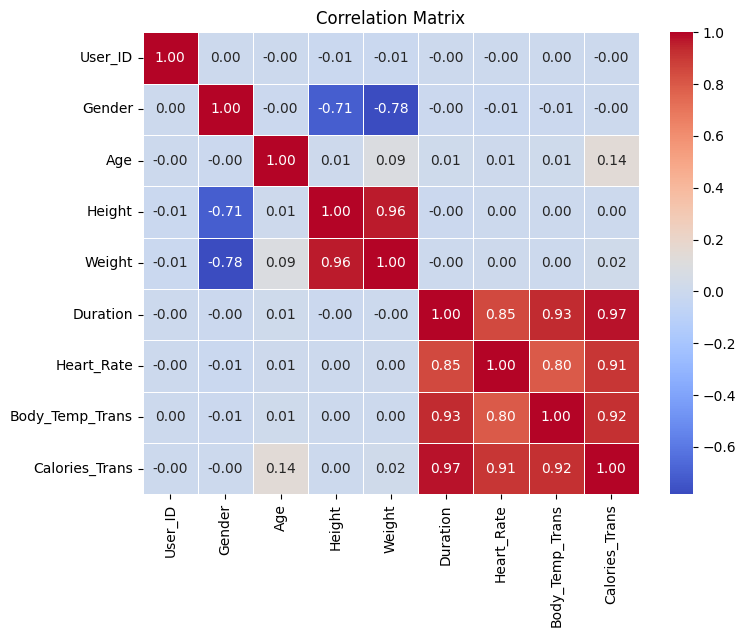

In [18]:
# Calculating the correlation between features
corr_matrix = df.corr()

# Plotting the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [19]:
# Features to remove
features_to_remove = ["Duration", "Height"]

# Removing highly correlated features to
# reduce multicollinearity
df.drop(features_to_remove, axis=1, inplace=True)

# Removing IDs
df.drop("User_ID", axis=1, inplace=True)

##Feature Selection

In [20]:
regressor = RandomForestRegressor(n_estimators=200, random_state=42)

# Splitting the Data to features and a target
X, y = df.drop('Calories_Trans', axis=1), df['Calories_Trans']

# Fitting the model
regressor.fit(X, y)

RandomForestRegressor(n_estimators=200, random_state=42)

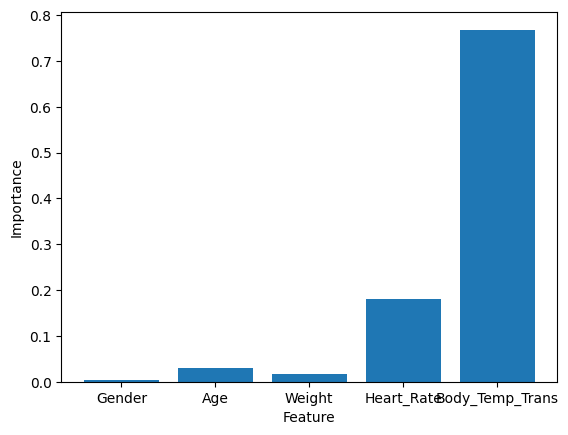

In [21]:
# Plotting the feature importances
plt.bar(X.columns, regressor.feature_importances_)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [22]:
# Removing the Gender feature
X.drop('Gender', axis=1, inplace=True)

# Model Training

## Splitting the data

In [23]:
from sklearn.model_selection import train_test_split

# Splitting the data to train, validation and test set
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size = 0.5,
    random_state=42)

In [24]:
X_train.columns

Index(['Age', 'Weight', 'Heart_Rate', 'Body_Temp_Trans'], dtype='object')

## Data Scaling

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scaling the data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [26]:
# Save the scaler to disk
scaler_path = '/content/drive/MyDrive/Machine Learning/Final Projects/Calories Burnt Prediction/scaler.pkl'
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)

## Models Training

ANN

In [27]:
# Define the model
ann_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
])

# Compile the model
ann_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Identifing callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                 patience=5)

# Fitting the model
history = ann_model.fit(X_train_scaled, y_train, epochs=100, callbacks=[early_stopping],
                    validation_data=(X_val_scaled, y_val), batch_size=32)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 108.0696 - mae: 8.3532 - val_loss: 5.4710 - val_mae: 1.8828
Epoch 2/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7518 - mae: 1.7360 - val_loss: 1.9891 - val_mae: 1.1118
Epoch 3/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8089 - mae: 1.0620 - val_loss: 1.4133 - val_mae: 0.9385
Epoch 4/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4003 - mae: 0.9332 - val_loss: 1.3302 - val_mae: 0.9090
Epoch 5/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3511 - mae: 0.9143 - val_loss: 1.2985 - val_mae: 0.8983
Epoch 6/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2915 - mae: 0.8950 - val_loss: 1.3170 - val_mae: 0.9079
Epoch 7/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2594 - mae: 0.8859 - val_loss: 1.2847 - val_mae: 0.8947
Epoch 8/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2332 - mae: 0.8781 - val_loss: 1.2870 - val_mae: 0.8948
Epoch 9/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - los

In [28]:
# Predicting the test data
y_pred_transformed = ann_model.predict(X_test_scaled)
y_pred_inverse = inv_boxcox(y_pred_transformed, boxcox_lambda['Calories']) - 1

y_test_inverse = inv_boxcox(y_test, boxcox_lambda['Calories']) - 1

# Applying MAE evaluation metric
ann_mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"Mean Absolute Error (MAE): {ann_mae:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Absolute Error (MAE): 9.9228


Random Forest

In [29]:
param_grid = {
    'n_estimators' : [250, 300, 350, 400],
    'max_depth' : [None, 10, 20, 30],
    'min_samples_split': [7, 10, 13],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid,cv=3, n_jobs=-1, verbose=2)

# Fitting the model to the data
rf_grid_search.fit(X_train_scaled, y_train)

# Display best parameters
print('Best Parameters : ', rf_grid_search.best_params_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Parameters :  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 250}


In [30]:
# Predicting the test data
y_pred_transformed = rf_grid_search.best_estimator_.predict(X_test_scaled)
y_pred_inverse = inv_boxcox(y_pred_transformed, boxcox_lambda['Calories']) - 1

# Applying MAE evaluation metric
rf_mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"Mean Absolute Error (MAE): {rf_mae:.4f}")

Mean Absolute Error (MAE): 10.2721


XGBoost

In [31]:
param_grid = {
    "n_estimators" : [500, 550, 600],
    'learning_rate': [0.15, 0.2, 0.3],
    "max_depth" : [2, 3, 4],
    "min_split_loss" : [0, 0.01, 0.1],
    "min_child_weight" : [1, 3, 5]
}

# grid search
xgb_grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
                        param_grid, cv=3, n_jobs=-1, verbose=2)

# fitting the model
xgb_grid.fit(X_train_scaled, y_train)

# Getting the best Parameters
print('Best Parameters : ', xgb_grid.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters :  {'learning_rate': 0.15, 'max_depth': 2, 'min_child_weight': 1, 'min_split_loss': 0.01, 'n_estimators': 550}


In [32]:
# Predicting the test data
y_pred_transformed = xgb_grid.best_estimator_.predict(X_test_scaled)
y_pred_inverse = inv_boxcox(y_pred_transformed, boxcox_lambda['Calories']) - 1

# Applying MAE evaluation metric
xgb_mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"Mean Absolute Error (MAE): {xgb_mae:.4f}")

Mean Absolute Error (MAE): 9.9420


## Models Comparison

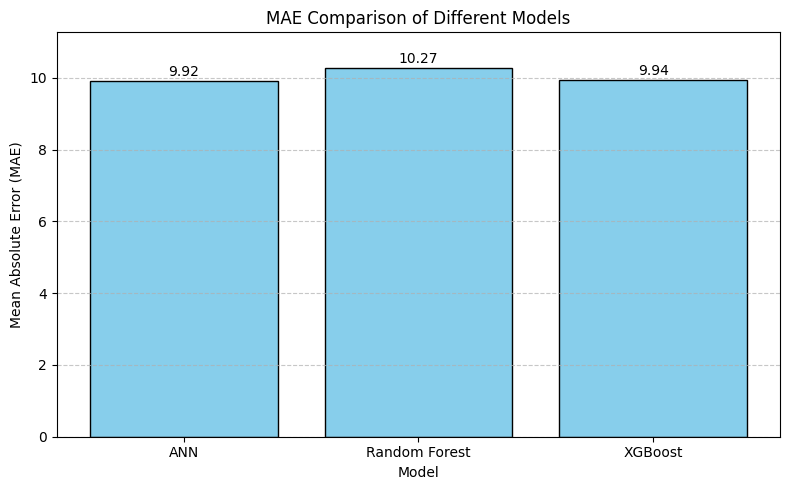

In [33]:
models = ['ANN', 'Random Forest', 'XGBoost']
mae_values = [ann_mae, rf_mae, xgb_mae]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, mae_values, color='skyblue', edgecolor='black')

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom')

# Labels and title
plt.title('MAE Comparison of Different Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Model')
plt.ylim(0, max(mae_values) + 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [36]:
# check if MAE is acceptable
acc_mae_percent = (ann_mae / calories_avg)*100
print(f"The mean Absoulute error of ANN is {acc_mae_percent:.2f}%")

The mean Absoulute error of ANN is 11.15%


## Saving the Model

In [37]:
file_path = '/content/drive/MyDrive/Machine Learning/Final Projects/Calories Burnt Prediction/ann_model.pkl'

with open(file_path, 'wb') as f:
    pickle.dump(ann_model, f)

print(f"Model saved to {file_path}")

Model saved to /content/drive/MyDrive/Machine Learning/Final Projects/Calories Burnt Prediction/ann_model.pkl
